# Анализ поведения пользователей в мобильном приложении

## Ссылки

- <a href='https://drive.google.com/file/d/16FCb2Stj9MKA95Bqn-c9-yabNEFc5Aeo/view?usp=sharing'> Презентация проекта (PDF) </a>


- <a href='https://public.tableau.com/profile/tatyana.chernyavskaya#!/vizhome/final_mobile-app/mobile_app'> Дашборд в Tableau Public</a>:

  - Диаграмма, отображающая количество событий по дням;
  - Гистограмма, отображающая количество пользователей, пришедших из разных источников;
  - Фильтр дашборда по типу события.

## Описание проекта

### Контекст

Мобильное приложение (далее МП) «Ненужные вещи» — в нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

Целевой сценарий использования МП:
1. Пользователь ищет объявления, релевантные его запросу (например, купить фотоаппарат или удочку).
2. Просматривает подходящие объявления.
3. В заинтересовавших его объявлениях **просматривает контакты продавца**.
4. Звонит продавцу и заключает сделку.

Целевое событие всего сервиса — совершение сделки (покупка/продажа вещи). Но в рамках данного исследования целевым действием является просмотр контактов (логируемое событие `contacts_show` / `show_contacts`). Данное действие необходимо для защиты данных продавцов от парсинга и дальнейшего спама. Но с точки зрения удобства использования и конверсии в совершение сделки, это действие является дополнительной преградой для пользователя.


### Цель и ключевая гипотеза

Необходимо подготовить данные для принятия решения о судьбе действия «просмотр контактов». По результатам исследования product-менеджер выступит с презентацией на совете директоров, где будет принято решение о том, что делать с этим действием — оставить / убрать / изменить.

Ключевая гипотеза — на этапе просмотра контактов «отваливается» большое количество пользователей, то есть происходит существенное снижение конверсии в звонок.


### Задачи

1. Оценить, какие действия чаще совершают те пользователи, которые просматривают контакты;
2. Оценить влияние необходимости просмотра контактов на конверсию в звонок;
3. Проверить статистические гипотезы.

## Описание данных

Датасет содержит данные о событиях, совершенных в МП. В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Колонки в `mobile_sources.csv`: 
- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Колонки в `mobile_dataset.csv`:
- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:
- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` и `show_contacts` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search_1` — `search_7` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.

## <a id='content'>План проекта</a>

1. [Подготовка и настройка](#step-0)
2. [Загрузка данных и изучение общей информации о датасетах](#step-1)
3. [Предобработка данных](#step-2)
4. [Исследовательский анализ данных (EDA)](#step-3)
5. [Изучение связи целевого и других событий](#step-4)
6. [Проверка статистических гипотез](#step-5)
7. [Общие выводы](#results)

---

## <a id='step-0'>Шаг 0. Подготовка и настройка</a>

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math as mth
from datetime import datetime

from scipy import stats as st
from termcolor import colored # раскраска текста

import matplotlib.pyplot as plt
import seaborn as sns

import calendar # дни недели текстом, а не цифрами

In [2]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

### Настройки для графиков

In [3]:
# настройки графиков
large = 16; medium = 14; small = 12

params = {'axes.titlesize': large,
          'axes.labelsize': medium,
          'legend.fontsize': medium,
          'figure.titlesize': large,
          'figure.figsize': (10, 6),
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'axes.grid': True,
          'legend.loc': 'upper left',
          'axes.titlepad': 20.0, # отступ названия графика
          'axes.labelpad': 8.0, # отступ для подписей осей
          'legend.title_fontsize': medium,
         }
plt.rcParams.update(params)
# plt.rcParams.keys() # список параметров и их значения

plt.style.use('seaborn-muted') # единый стиль графиков
sns.set_style('white')

### Собственные функции для автоматизации дальнейших действий

Функция для подписи значений на bar-графиках:

In [4]:
def make_annotates(chart):
    for p in chart.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        chart.annotate('{:.0f}'.format(y), (x, y), size=12, ha='center', va='bottom')
    return

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='step-1'>Шаг 1. Загрузка данных и изучение общей информации о датасетах</a>

1. Загрузим датасеты в переменные:

In [5]:
users = pd.read_csv('/datasets/mobile_soures.csv')
events = pd.read_csv('/datasets/mobile_dataset.csv')

2. Посмотрим на примеры строк в датасетах:

In [6]:
for data in [users, events]:
    display(data.sample(5))

,userId,source
1253,c48e0935-d425-43bc-8768-67a2ea07dbcd,other
4153,57a6b317-01f6-4c61-ba7c-afb3e8444148,google
1984,fbd33488-4b60-48ef-bc82-3ec268b5ae9b,yandex
661,fa2b7f11-8713-48f1-b8bf-21f2fcb6b278,yandex
575,8911014a-89b7-4f0c-96de-dfa6b3dd8ab2,google


,event.time,event.name,user.id
63264,2019-10-30 19:33:32.839189,tips_show,081bb564-703e-4f1c-9016-ac9460dec5bf
73756,2019-11-03 21:26:44.500826,search_1,961a89e9-00b8-4168-a1ba-cbb036dd2f4e
28843,2019-10-18 19:00:19.348829,tips_show,1e49028e-e90e-4b27-9467-c101d8f94156
46929,2019-10-25 12:34:11.993084,tips_show,2ed1eabe-8bbb-4418-92d8-969d9963e6ea
8710,2019-10-10 17:28:54.750204,tips_click,9d2c3d71-c6e8-4957-bc3d-e3a00752519d


3. Изучим общую информацию о датасетах:

In [7]:
for data in [users, events]:
    display(data.info())
    display(data.describe())

    duplicated_cnt = data.duplicated().sum()

    print()
    if duplicated_cnt > 0:
        print('Количество пропусков:', duplicated_cnt)
        display(data[data.duplicated()])
    else:
        print('Дубликатов нет.')

    print()
    print('----------')
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
userId    4293 non-null object
source    4293 non-null object
dtypes: object(2)
memory usage: 67.2+ KB


None

,userId,source
count,4293,4293
unique,4293,3
top,dcf534b4-da9f-42c2-b1dc-e8c8dc42dd13,yandex
freq,1,1934



Дубликатов нет.

----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
event.time    74197 non-null object
event.name    74197 non-null object
user.id       74197 non-null object
dtypes: object(3)
memory usage: 1.7+ MB


None

,event.time,event.name,user.id
count,74197,74197,74197
unique,74197,16,4293
top,2019-10-12 22:45:01.197976,tips_show,cb36854f-570a-41f4-baa8-36680b396370
freq,1,40055,478



Дубликатов нет.

----------



4. Посмотрим, есть ли у нас пользователи с несколькими источниками:

In [8]:
if len(users) < users['userId'].nunique():
    users_sources = users.groupby(['userId']).agg({'source':'count'}).query('source > 1')
    print('Пользователей с несколькими источниками:', len(users_sources))
else:
    print('Для каждого пользователя зафиксирован только один источник.')

Для каждого пользователя зафиксирован только один источник.


5. Посмотрим на типы событий:

In [9]:
events['event.name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event.name, dtype: int64

### Промежуточные выводы

Датасет `users` (источники прихода пользователей):
- Пропусков и дубликатов нет;
- В спсике 4293 пользователя;
- Для каждого пользователя указан только один источник;
- Нужно переименовать столбец `userId` в `user_id` для единообразия в стиле именований.

Датасет `events` (лог событий):
- Пропусков и дубликатов нет;
- В логе 74197 событий;
- Стоит переименовать столбцы (вместо точки использовать нижнее подчеркивание);
- Нужно привести тип данных в столбце `event.time` к дате и времени;
- Добавить столбец с датой событий;
- Объединить под общим названием события с типами `contacts_show` и `show_contacts`, так как они обозначают одно и то же действие — просмотр контактов.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='step-2'>Шаг 2. Предобработка данных</a>

1. Переименуем столбцы:

In [10]:
users = users.rename(columns = {'userId':'user_id'})
users.sample()

,user_id,source
3919,057739fd-4b33-47b3-8140-b10fa48ae90e,google


In [11]:
events = events.rename(columns = {'event.time':'event_time', 'event.name':'event_name', 'user.id':'user_id'})
events.sample()

,event_time,event_name,user_id
66335,2019-10-31 20:34:58.406182,photos_show,dea738ff-1103-40c0-bacb-1aa4bc9dcf71


2. Приведем столбец `event_time` датасета `events` к дате и времени, и создадим отдельный столбец только с датой:

In [12]:
events['event_time'] = pd.to_datetime(events['event_time'], format='%Y-%m-%d')
events['event_date'] = pd.to_datetime(events['event_time'].dt.date)

In [13]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 4 columns):
event_time    74197 non-null datetime64[ns]
event_name    74197 non-null object
user_id       74197 non-null object
event_date    74197 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 2.3+ MB


In [14]:
events.sample()

,event_time,event_name,user_id,event_date
41690,2019-10-23 16:39:37.723518,search_6,e4f99a9d-3c13-4972-ae47-690dad667749,2019-10-23


3. Заменим значение `show_contacts` на `contacts_show` в столбце `event_name` датасета `events`:

In [15]:
events['event_name'] = events['event_name'].apply(lambda x: 'contacts_show' if x == 'show_contacts' else x)
events['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4529
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
Name: event_name, dtype: int64

### Промежуточные результаты

Для удобства дальнейшей работы мы переименовали столбцы, привели столбец с датой и временем к нужному формату и выделили в отдельный только дату события.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='step-3'>Шаг 3. Исследовательский анализ данных (EDA)</a>

1. Посмотрим, сколько у нас пользователей и из каких источников они пришли:

In [16]:
print('Пользователей всего:', users['user_id'].nunique())

Пользователей всего: 4293


In [17]:
print('Пользователей, совершивших хотя бы одно действие:', events['user_id'].nunique())

Пользователей, совершивших хотя бы одно действие: 4293


In [18]:
sources = (users
           .groupby(['source'], as_index=False)
           .agg({'user_id':'nunique'})
           .sort_values(by='user_id', ascending=False))

sources = sources.rename(columns = {'user_id':'users_cnt'})
sources['pcnt'] = sources['users_cnt'].apply(lambda x: x / sources['users_cnt'].sum())
sources

,source,users_cnt,pcnt
2,yandex,1934,0.450501
1,other,1230,0.286513
0,google,1129,0.262986


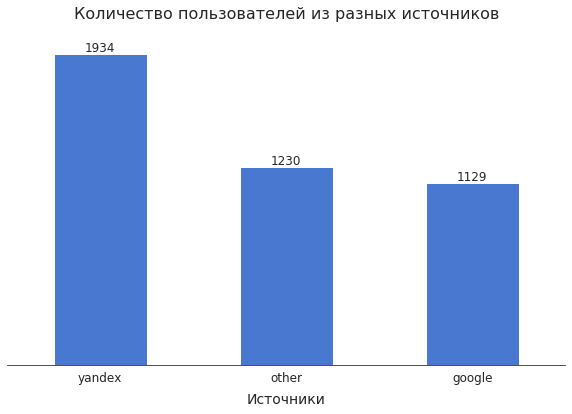

In [19]:
ax = sources.plot.bar(x='source', y='users_cnt', legend=False)
plt.title('Количество пользователей из разных источников')
plt.xlabel('Источники')
ax.axes.get_yaxis().set_visible(False)
plt.xticks(rotation=0)
make_annotates(ax)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

2. Посмотрим поближе на события в логе:

In [20]:
print('Событий всего:', len(events))

Событий всего: 74197


In [21]:
print(f'В логе представлены события за период с {events["event_date"].min().date()} по {events["event_date"].max().date()}')

В логе представлены события за период с 2019-10-07 по 2019-11-03


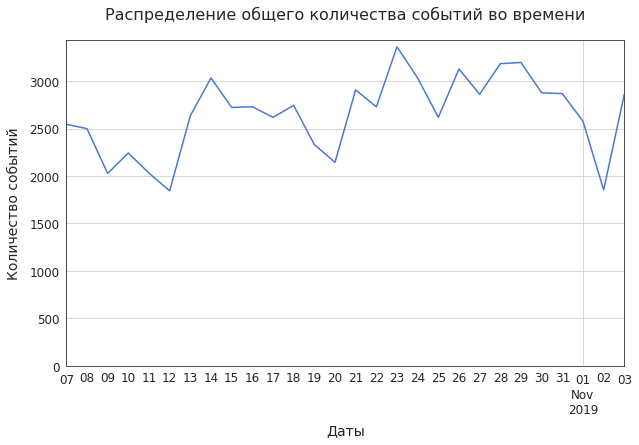

In [22]:
events.groupby(['event_date']).agg({'event_time':'count'}).plot(grid=True, legend=False)
plt.title('Распределение общего количества событий во времени')
plt.xlabel('Даты')
plt.ylabel('Количество событий')
plt.ylim(bottom=0)
plt.show()

Посмотрим, по каким дням недели больше / меньше событий в целом:

In [23]:
events['week_day'] = events['event_date'].apply(lambda x: calendar.day_name[x.weekday()])
events.sample(5)

,event_time,event_name,user_id,event_date,week_day
39337,2019-10-22 21:01:21.712401,tips_show,e549f8ef-653b-4c5c-a6bd-8970e6bd860b,2019-10-22,Tuesday
65767,2019-10-31 16:58:06.961951,tips_show,1d3647a2-329f-4b79-adc4-594df8054a29,2019-10-31,Thursday
35241,2019-10-21 14:14:23.578477,tips_show,bd5fb634-bc26-4669-9c4e-4f57c23fd204,2019-10-21,Monday
42308,2019-10-23 19:05:51.054465,photos_show,714059e0-8240-4539-95e1-a4ec22df0d0f,2019-10-23,Wednesday
47485,2019-10-25 15:34:24.939149,tips_show,92cf0b4c-1e0f-400a-b451-89031b28c245,2019-10-25,Friday


In [24]:
events.groupby(['week_day']).agg({'event_time':'count'}).sort_values(by='event_time', ascending=False)

,event_time
week_day,
Monday,11671
Tuesday,11145
Wednesday,10995
Thursday,10762
Sunday,10501
Friday,9969
Saturday,9154


Количество событий на каждого пользователя:

In [25]:
events_per_user = (events
                   .groupby(['user_id'], as_index=False)
                   .agg({'event_time':'count'})
                   .rename(columns={'event_time':'event_cnt'}))
events_per_user

,user_id,event_cnt
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8
...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,17
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,7
4290,ffcf50d9-293c-4254-8243-4890b030b238,2
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,13


In [26]:
print('Меньше всего событий на одного пользователя:', events_per_user['event_cnt'].min())
print('Максимум событий на одного пользователя:', events_per_user['event_cnt'].max())

Меньше всего событий на одного пользователя: 1
Максимум событий на одного пользователя: 478


Распределение количества событий на одного пользователя:

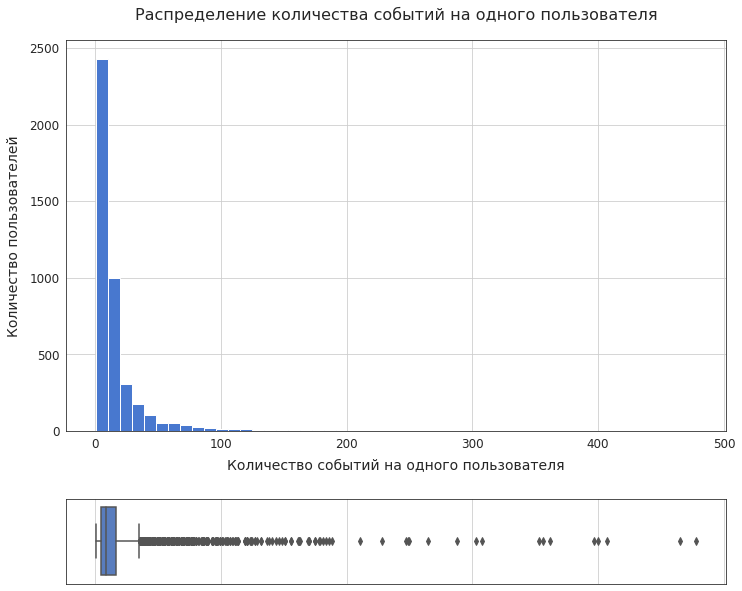

In [27]:
fig = plt.figure(figsize=(16, 10))
grid = plt.GridSpec(4, 4, hspace=0.8)

# создаем оси
ax_main = fig.add_subplot(grid[:-1, :-1])
plt.grid(True)

ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[])
plt.grid(True)

# на главных осях - гистограмма
ax_main.hist(events_per_user['event_cnt'], bins=50)

# снизу - боксплот
sns.boxplot(events_per_user['event_cnt'], ax=ax_bottom, orient='h')
ax_bottom.set(xlabel='')

ax_main.set(title='Распределение количества событий на одного пользователя', \
            xlabel='Количество событий на одного пользователя', \
            ylabel='Количество пользователей')

plt.show()

Посмотрим, где заканчиваются усы боксплота:

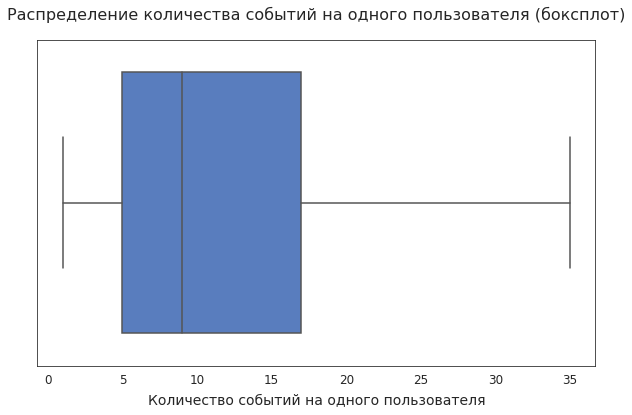

In [28]:
sns.boxplot(events_per_user['event_cnt'], showfliers=False)
plt.title('Распределение количества событий на одного пользователя (боксплот)')
plt.xlabel('Количество событий на одного пользователя')
plt.ylabel('')
plt.show()

Видим, что есть выбросы. Но все-таки посмотрим среднее и медиану по всем данным:

In [29]:
print('Количество событий на одного пользователя:\n')
print('Среднее: {:.1f}'.format(events_per_user['event_cnt'].mean()))
print('Медиана: {:.1f}'.format(events_per_user['event_cnt'].median()))

Количество событий на одного пользователя:

Среднее: 17.3
Медиана: 9.0


Отбросим выбросы и посчитаем среднее и медиану по очищенным данным:

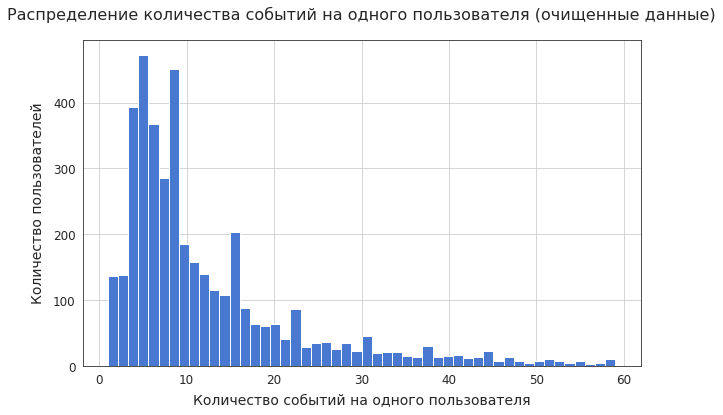

In [30]:
# запишем правый перцентиль
right_cut = events_per_user.event_cnt.quantile(0.95)
events_per_user_filtered = events_per_user.query('event_cnt <= @right_cut')

events_per_user_filtered['event_cnt'].hist(bins=50)
plt.title('Распределение количества событий на одного пользователя (очищенные данные)')
plt.xlabel('Количество событий на одного пользователя')
plt.ylabel('Количество пользователей')
plt.show()

In [31]:
print('Количество событий на одного пользователя (очищенные данные):\n')
print('Среднее: {:.1f}'.format(events_per_user_filtered['event_cnt'].mean()))
print('Медиана: {:.1f}'.format(events_per_user_filtered['event_cnt'].median()))

Количество событий на одного пользователя (очищенные данные):

Среднее: 12.4
Медиана: 8.0


Соединяем данные по пользователям и лог событий:

In [32]:
df = users.merge(events, on='user_id')
df.sample(5)

,user_id,source,event_time,event_name,event_date,week_day
70894,3ea0e646-5c5a-4b16-b364-fc992ea4eb5e,yandex,2019-11-01 14:54:26.927965,tips_show,2019-11-01,Friday
24925,0c498b2b-60c2-430f-a98f-100aaf6476a5,yandex,2019-10-14 01:03:36.228465,tips_show,2019-10-14,Monday
35132,71b9ae11-cba2-4a7c-8ce6-9d422f62af8c,other,2019-10-17 08:02:46.141049,search_5,2019-10-17,Thursday
17893,2d9366fa-7c0a-4e57-a559-e730f2341b45,yandex,2019-10-11 18:25:11.848741,contacts_show,2019-10-11,Friday
29748,02012123-f8ee-40f4-8ccd-c5859f3fbc41,google,2019-10-15 14:17:50.851617,advert_open,2019-10-15,Tuesday


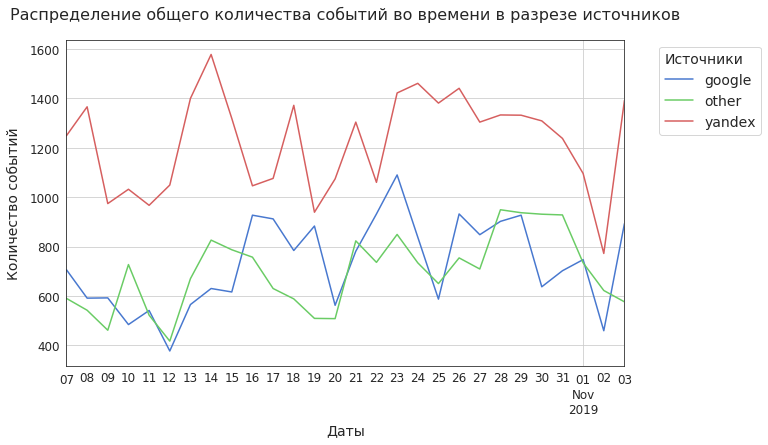

In [33]:
df.pivot_table(index='event_date', columns='source', values='event_time', aggfunc='count').plot(grid=True)
plt.title('Распределение общего количества событий во времени в разрезе источников')
plt.xlabel('Даты')
plt.ylabel('Количество событий')

# смещаем легенду за пределы графика
leg = plt.legend(title='Источники', bbox_to_anchor=(1.05, 1))
# выравнивание заголовка легенды слева
leg._legend_box.align = 'left'

plt.show()

Посмотрим количество событий на одного пользователя в разрезе источников:

In [34]:
# запишем id пользователей из очищенных от выбросов данных
users_ids_filteres = list(events_per_user_filtered['user_id'])
len(users_ids_filteres)

4083

In [35]:
(df
 .query('user_id in @users_ids_filteres')
 .groupby(['source', 'user_id']).agg({'event_time':'count'})
 .groupby(['source']).agg({'event_time':'mean'}))

,event_time
source,
google,12.870577
other,11.943878
yandex,12.376978


### Промежуточные выводы

В ходе исследовательского анализа данных выяснили следующие моменты:

- Всего у нас 4293 пользователя, при чем каждый из них совершил хотя бы одно действие. Максимум событий на одного пользователя = 478;
- Больше всего пользователей пришло из Яндекса (1934 = 45%);
- В логе представлены 74197 событий за период с 7 октября по 3 ноября;
- Распределение общего количества событий во времени неравномерное: есть всплески и провалы. Больше событий суммарно пользователи совершают в начале недели (понедельник – среда), меньше всего — по субботам;
- В среднем, на одного пользователя приходится 12.4 событий (медиана = 9);
- По источникам каких-то закономерностей выявить не удалось ни в среднем количестве событий на пользователя, ни в распределении количества событий во времени.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='step-4'>Шаг 4. Изучение связи целевого и других событий</a>

### Анализ воронки событий

1. Посмотрим по событиям, сколько и какая доля пользователей совершили их хотя бы один раз:

In [36]:
# количество уникальных пользователей
users_total = df['user_id'].nunique()
users_total

4293

In [37]:
events_per_users = (df
                    .groupby(['event_name'])
                    .agg({'user_id':'nunique'})
                    .rename(columns = {'user_id':'users_cnt'})
                    .sort_values(by=['users_cnt'], ascending=False)
                    .assign(users_pcnt = lambda x: round((x.users_cnt / users_total * 100),1))
                    .reset_index()
                   )
events_per_users

,event_name,users_cnt,users_pcnt
0,tips_show,2801,65.2
1,map,1456,33.9
2,photos_show,1095,25.5
3,contacts_show,981,22.9
4,search_1,787,18.3
5,advert_open,751,17.5
6,search_5,663,15.4
7,search_4,474,11.0
8,favorites_add,351,8.2
9,search_6,330,7.7


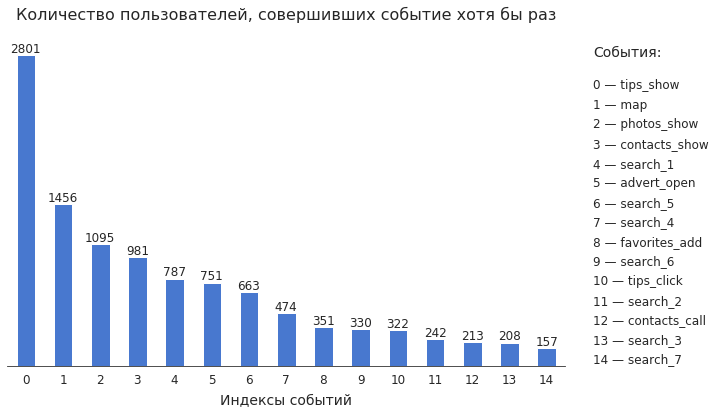

In [38]:
ax = events_per_users[['event_name','users_cnt']].plot(kind='bar', legend=False)

ax.set_title('Количество пользователей, совершивших событие хотя бы раз')
ax.set_xlabel('Индексы событий')
ax.axes.get_yaxis().set_visible(False)
plt.xticks(rotation=0)
make_annotates(ax)

ax.annotate('События:', xy=(1.05, 0.95), xycoords=ax.get_window_extent, size=14)

# расшифровка индексов событий
for i in range(0, len(events_per_users)):    
    ax.annotate('{} — {}'.format(i, events_per_users['event_name'][i]),
                xy=(1.05, 0.85 - i*0.06), xycoords=ax.get_window_extent, size=12)

sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

Видим, что событий довольно много. Основываясь на здравом смысле, будем считать, что упрощенная воронка выглядит примерно так:

1. Вход в сервис (общее количество пользователей),
2. Просмотр контактов (`contacts_show`),
3. Звонок по номеру из объявления (`contacts_call`).

Остальные действия (даже открытие карточки объявления) кажутся необязательными для совершения целевого действия, поэтому не будем их учитывать в воронке.

In [39]:
funnel_events_list = ['contacts_show', 'contacts_call']

funnel_events = events_per_users.query('event_name in @funnel_events_list')
funnel_events

,event_name,users_cnt,users_pcnt
3,contacts_show,981,22.9
12,contacts_call,213,5.0


Добавим первый шаг — вход в приложение:

In [40]:
funnel_events = funnel_events.append({'event_name':'start', 'users_cnt':users_total, 
                                      'users_pcnt':users_total/users_total * 100},
                                     ignore_index=True)
funnel_events = funnel_events.sort_values(by='users_cnt', ascending=False)
funnel_events

,event_name,users_cnt,users_pcnt
2,start,4293,100.0
0,contacts_show,981,22.9
1,contacts_call,213,5.0


Доля пользователей, переходящих на каждый следующий шаг воронки от числа пользователей на предыдущем:

In [41]:
# для каждого столбца запишем в отдельный столбец количество пользователей, совершивших предыдущий шаг
funnel_events['prev'] = (funnel_events['users_cnt']
                         .shift(1)
                         .fillna(funnel_events['users_cnt'].max())
                         .astype('int'))
funnel_events

,event_name,users_cnt,users_pcnt,prev
2,start,4293,100.0,4293
0,contacts_show,981,22.9,4293
1,contacts_call,213,5.0,981


In [42]:
# посчитаем долю пользователей, переходящих на следующий шаг воронки от числа пользователей на предыдущем:
funnel_events['prev_pcnt'] = round(funnel_events['users_cnt'] / funnel_events['prev'] * 100, 1)
funnel_events

,event_name,users_cnt,users_pcnt,prev,prev_pcnt
2,start,4293,100.0,4293,100.0
0,contacts_show,981,22.9,4293,22.9
1,contacts_call,213,5.0,981,21.7


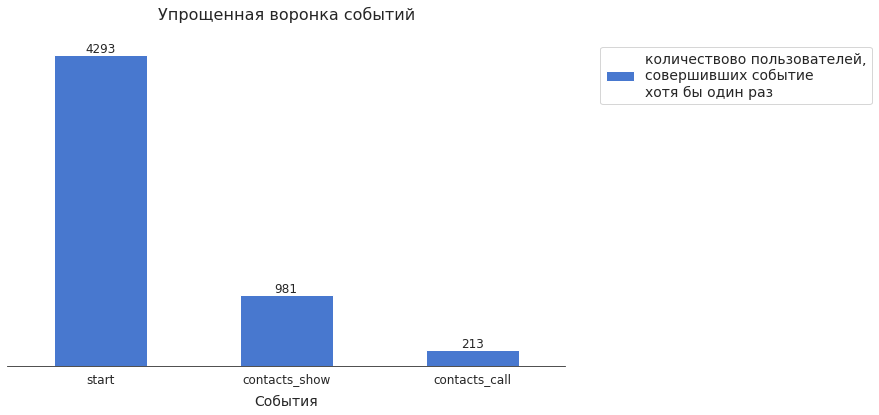

In [43]:
ax = funnel_events.plot.bar(x='event_name', y='users_cnt')
plt.xticks(rotation=0)
plt.title('Упрощенная воронка событий')
plt.xlabel('События')
plt.legend(labels=['количествово пользователей,\nсовершивших событие\nхотя бы один раз'], bbox_to_anchor=(1.05, 1))
make_annotates(ax)
ax.axes.get_yaxis().set_visible(False)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

### Анализ корреляций

Посчитаем для каждого пользователя количество событий каждого типа:

In [44]:
events_per_users = (df
                    .pivot_table(index='user_id', columns='event_name', values='event_time', aggfunc='count')
                    .reset_index()
                    .fillna(0))
events_per_users.sample(5)

event_name,user_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
1169,44623482-f318-4ef2-90a8-65729688cb00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3414,cbd32396-2984-4a55-a92d-d720a5b52a53,0.0,0.0,2.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
310,110640ac-8560-4315-8d4d-0490632e927d,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
321,116085d7-377c-4773-b5a4-d854bf3a8a2d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,9.0
3253,c30289d2-693b-44c5-b097-9b75b106ede7,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Построим и визуализируем матрицу корреляций, убрав из анализа поле `user_id`:

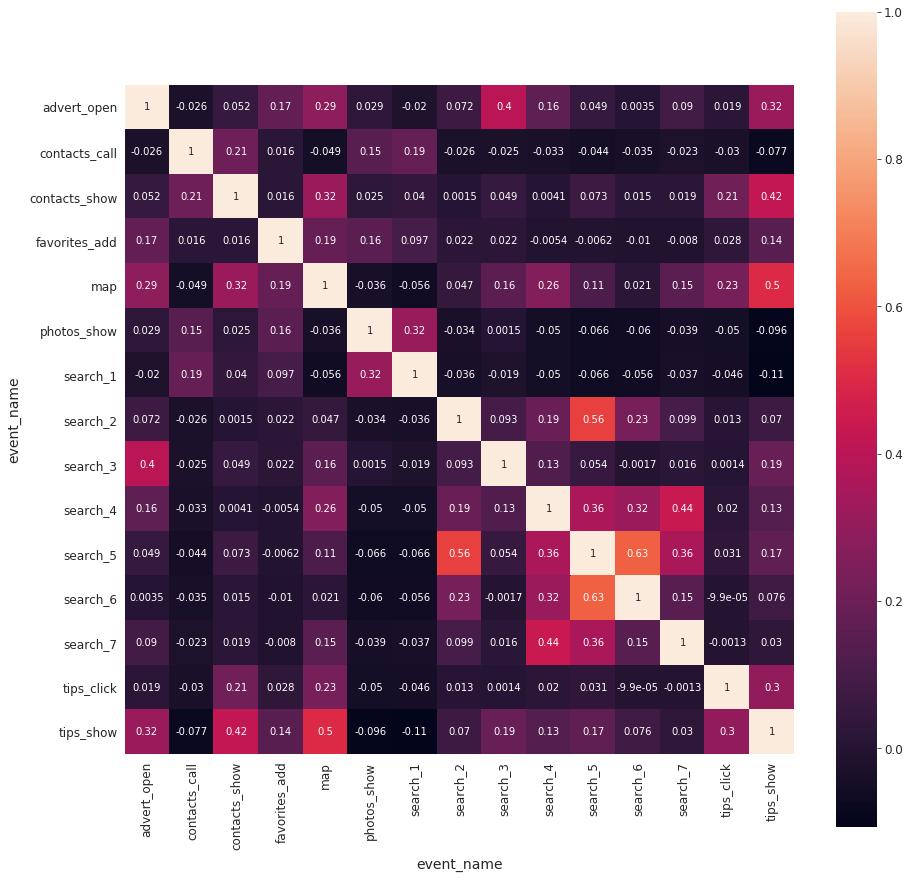

In [45]:
plt.figure(figsize = (15,15))
sns.heatmap(events_per_users.drop(['user_id'], axis=1).corr(), square = True, annot = True)
plt.show()

Видим, что целевое событие `contacts_show` положительно коррелирует с событием `tips_show` (0.42).

Посмотрим на распределение количества событий `contacts_show` и `tips_show` во времени:

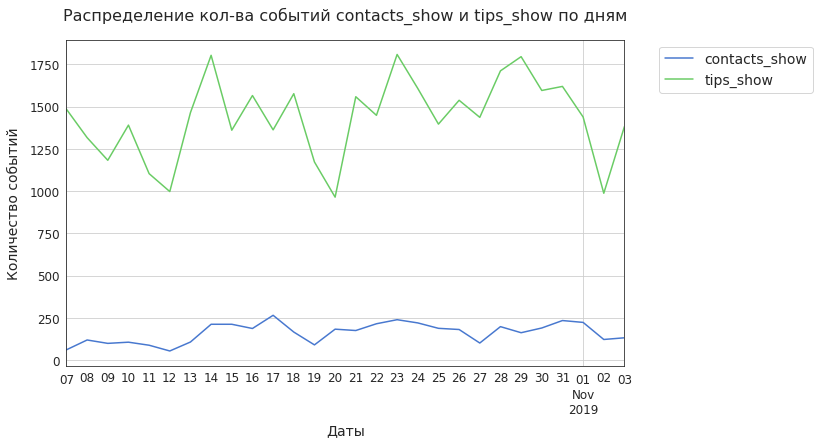

In [46]:
ax = df[df['event_name'] == 'contacts_show'].groupby(['event_date']).agg({'event_time':'count'}).plot()
df[df['event_name'] == 'tips_show'].groupby(['event_date']).agg({'event_time':'count'}).plot(ax=ax, grid=True)
plt.legend(labels=('contacts_show','tips_show'), bbox_to_anchor=(1.05, 1))
plt.title('Распределение кол-ва событий contacts_show и tips_show по дням')
plt.xlabel('Даты')
plt.ylabel('Количество событий')
plt.show()

Каких-то явных зависимостей в распределении событий по времени не видно. Скорее всего, связь более сложная (проверим это на этапе работы со статистическими гипотезами).

### Анализ групп пользователей (совершили или нет целевое действие)

Выделим группы пользователей:
- Те, кто совершил целевое событие `contacts_show` хотя бы один раз;
- Те, кто не совершал целевое событие ни разу.

In [47]:
# id пользователей, совершивших целевое событие хотя бы один раз
goal_users = list(df.loc[df['event_name'] == 'contacts_show', 'user_id'].unique())

goal_users_cnt = len(goal_users)
goal_users_pcnt = goal_users_cnt / users['user_id'].nunique()
print('Кол-во пользователей, совершивших целевое событие хотя бы один раз: {:.0f} ({:.1%})'\
      .format(goal_users_cnt, goal_users_pcnt))

Кол-во пользователей, совершивших целевое событие хотя бы один раз: 981 (22.9%)


Посмотрим, какая доля пользователи в каждой группе совершали другие события:

In [48]:
def make_funnel(df):
    users_cnt = df['user_id'].nunique()
    events_per_users = (df
                        .groupby(['event_name'])
                        .agg({'user_id':'nunique'})
                        .rename(columns = {'user_id':'users_cnt'})
                        .sort_values(by=['users_cnt'], ascending=False)
                        .assign(users_pcnt = lambda x: round((x.users_cnt / users_cnt * 100),1))
                        .reset_index()
                       )
    return events_per_users

In [49]:
goal_users_df = df.query('user_id in @goal_users')
not_goal_users_df = df.query('user_id not in @goal_users')

In [50]:
goal_users_funnel = make_funnel(goal_users_df).rename(columns = {'users_cnt':'goal_cnt',
                                                                 'users_pcnt':'goal_pcnt'})

not_goal_users_funnel = make_funnel(not_goal_users_df).rename(columns = {'users_cnt':'not_goal_cnt',
                                                                         'users_pcnt':'not_goal_pcnt'})

In [51]:
groups_funnel = goal_users_funnel.merge(not_goal_users_funnel, on='event_name')
groups_funnel

,event_name,goal_cnt,goal_pcnt,not_goal_cnt,not_goal_pcnt
0,tips_show,516,52.6,2285,69.0
1,photos_show,339,34.6,756,22.8
2,map,289,29.5,1167,35.2
3,search_1,237,24.2,550,16.6
4,advert_open,138,14.1,613,18.5
5,favorites_add,136,13.9,215,6.5
6,search_5,114,11.6,549,16.6
7,tips_click,100,10.2,222,6.7
8,search_4,88,9.0,386,11.7
9,search_2,55,5.6,187,5.6


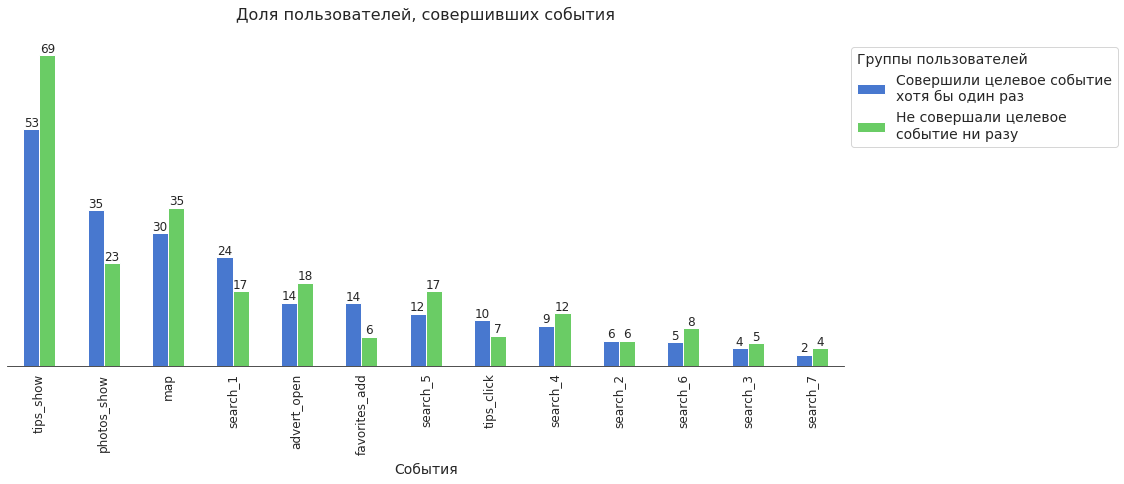

In [52]:
ax = groups_funnel.plot.bar(x='event_name', y=['goal_pcnt','not_goal_pcnt'], figsize=(15, 6))

plt.title('Доля пользователей, совершивших события')
plt.xlabel('События')

leg = plt.legend(title='Группы пользователей',
                 labels=['Совершили целевое событие\nхотя бы один раз', 'Не совершали целевое\nсобытие ни разу'],
                 bbox_to_anchor=(1, 1))
leg._legend_box.align = 'left'

make_annotates(ax)
ax.axes.get_yaxis().set_visible(False)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

Среди тех, кто совершил целевое событие `contacts_show`, выше доля пользователей, совершивших события `photos_show` и `search_1`.

### Сравнение пользователей из разных источников

Еще посмотрим, отличается ли доля пользователей, совершивших целевое событие `contacts_show`, в группах пользователей из разных источников.

In [53]:
# считаем количество пользователей по источникам
users_per_sources = (df.groupby(['source'], as_index=False).agg({'user_id':'nunique'})
                     .rename(columns={'user_id':'users_cnt'}))
users_per_sources

,source,users_cnt
0,google,1129
1,other,1230
2,yandex,1934


In [54]:
# считаем по источникам количество пользователей, совершивших целевое действие
users_per_sources_goal = (df.query('event_name == "contacts_show"')
                          .groupby(['source'], as_index=False).agg({'user_id':'nunique'})
                          .rename(columns={'user_id':'users_goal'}))
users_per_sources_goal

,source,users_goal
0,google,275
1,other,228
2,yandex,478


In [55]:
# соединяем
users_per_sources_pcnt = users_per_sources.merge(users_per_sources_goal, on='source')
users_per_sources_pcnt

,source,users_cnt,users_goal
0,google,1129,275
1,other,1230,228
2,yandex,1934,478


In [56]:
# считаем долю
users_per_sources_pcnt['pcnt'] = users_per_sources_pcnt['users_goal'] / users_per_sources_pcnt['users_cnt'] * 100
users_per_sources_pcnt = users_per_sources_pcnt.sort_values(by='pcnt', ascending=False)
users_per_sources_pcnt

,source,users_cnt,users_goal,pcnt
2,yandex,1934,478,24.715615
0,google,1129,275,24.357839
1,other,1230,228,18.536585


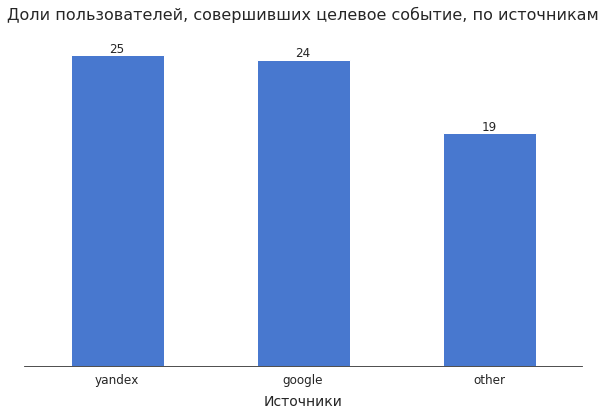

In [57]:
ax = users_per_sources_pcnt.plot.bar(x='source', y='pcnt', legend=False)
plt.xticks(rotation=0)
plt.title('Доли пользователей, совершивших целевое событие, по источникам')
plt.xlabel('Источники') 
make_annotates(ax)
ax.axes.get_yaxis().set_visible(False)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

### Промежуточные выводы

В данном разделе мы построили упрощенную воронку событий, изучили матрицу корреляций и посмотрели на различия в поведении пользователей, совершавших целевое событие `contacts_show` хотя бы один раз и не совершавших его ни разу:

- Целевое действие совершали только 22.9% от общего числа пользователей в логе;
- Их тех, кто посмотрел контакты, только 21.7% позвонили по номеру в контактах;
- Только 5% всех пользователей доходит до целевого действия всего приложения (звонок);
- Целевое событие `contacts_show` несильно положительно коррелирует с событием `tips_show` (коэффициент корреляции 0.42);
- Среди тех, кто совершил целевое событие `contacts_show`, выше доля пользователей, совершивших события `photos_show` и `search_1`;
- Доля пользователей, совершивших целевое событие `contacts_show` хотя бы раз, ниже среди пользователей, приходящих из источника `other`.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='step-5'>Шаг 5. Проверка статистических гипотез</a>

### Функция для проверки статистических гипотез

Так как в обеих гипотезах сравниваются конверсии, будем использовать `z-тест`.

Функция будет:
- Принимать на вход название целевого события, сравниваемые выборки из лога и значение критического уровня статистической значимости (alpha, по умолчанию будет равно 0.05);
- Рассчитывать и выводить долю пользователей, совершивших целевое действие, в каждой группе;
- Проводить z-тест и выводить его результаты.

In [58]:
def check_hyp(event, group_a, group_b, alpha=0.05):
    
    # считаем количество пользователей, совершивших целевое событие, в каждой группе
    successesA = group_a.loc[df_a['event_name']==event, 'user_id'].nunique()
    successesB = group_b.loc[df_b['event_name']==event, 'user_id'].nunique()
    
    # вытаскиваем общее количество пользователей
    totalA = group_a['user_id'].nunique()
    totalB = group_b['user_id'].nunique()
    
    # находим доли
    propA = successesA / totalA
    propB = successesB / totalB
    
    # выводим доли + количество пользователей в группах
    print()
    print(f'{propA:.0%} от {totalA} пользователей с событием {event} в группе «A»')
    print(f'{propB:.0%} от {totalB} пользователей с событием {event} в группе «B»')
    
    
    ########## проверяем гипотезу ##########
      
    # пропорция успехов в группах
    pA = successesA / totalA
    pB = successesB / totalB

    # пропорция успехов в комбинированной группе
    p_combined = (successesA + successesB) / (totalA + totalB)

    # разница пропорций в группах
    difference = pA - pB
    
    # выводим, в какой группе конверсия лучше
    if difference > 0:
        print(colored('Конверсия в группе B хуже.', 'red'))
    else:
        print(colored('Конверсия в группе B лучше.', 'green'))

    # статистика в стандартных отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/totalA + 1/totalB))

    # задаем стандартное нормальное распределение (среднее = 0, стандартное отклонение = 1)
    distr = st.norm(0, 1)
    
    # посчитаем, как далеко статистика уехала от нуля = какова вероятность получить такое отличие или больше
    # так как распределение статистики нормальное, вызовем метод cdf()
    # саму z-статистику возьмём по модулю методом abs(), чтобы получить правильный результат независимо от её знака
    # это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print()
    print(f'p-значение: {p_value:.4%}')

    # используем библиотеку termcolor
    if (p_value < alpha):
        print(colored('Отвергаем нулевую гипотезу: между долями есть значимая разница.', 'green'))
    else:
        print(colored('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.', 'red'))
    
    return

### Статистическая гипотеза №1

Конверсия в просмотры контактов различается у групп пользователей: одни совершают действия `tips_show` (увидел рекомендованные объявления) и `tips_click` (кликнул по рекомендованному объявлению), другие — только `tips_show`.

Формулируем нулевую и альтернативную гипотезы:

- H0: доли пользователей, совершивших целевое событие `contacts_show`, НЕ различаются у групп пользователей: группа A — совершали только `tips_show`, группа B — совершали `tips_show` и `tips_click`;
- H1: доли пользователей, совершивших целевое событие `contacts_show`, различаются у групп A и B пользователей.

In [59]:
# отберем события tips_show и tips_click
# потом посчитаем для каждого пользователя, сколько событий каждого типа он совершил
# потом определим для каждого пользователя, события скольки типов (одного или двух) он совершил
events_ab = (df.query('event_name == "tips_show" | event_name == "tips_click"')
             .groupby(['user_id','event_name'], as_index=False).agg({'event_time':'count'})
             .groupby(['user_id'], as_index=False).agg({'event_time':'nunique'})
             .rename(columns={'event_time':'event_types'})
            )
events_ab.sample(5)

,user_id,event_types
1765,a2311cac-437a-4e11-96d5-a492f5147771,1
596,3680f409-926a-4f40-8ef4-4f01c20459af,1
1564,8e60d403-f2b5-4966-8b85-819618698653,1
680,3e2ce582-a7bd-4bdb-856d-50e52abe0866,1
2094,c09257bb-5189-4887-93b4-90fe6c85f6ac,1


In [60]:
# соберем в разные датафреймы события пользователей, совершивших только tips_show (группа A)
# и пользователей, совершивших tips_show и tips_click (группа B)

da_ids = list(events_ab.query('event_types == 1')['user_id'])
len(da_ids)

2533

In [61]:
db_ids = list(events_ab.query('event_types == 2')['user_id'])
len(db_ids)

293

In [62]:
df_a = df.query('user_id in @da_ids')
df_b = df.query('user_id in @db_ids')

Так как на одном наборе данных мы проверяем две гипотезы, то нужно скорректировать уровень статистической значимости – используем поправку Бонферрони:

In [63]:
alpha = 0.05
alpha_adj = alpha / 2

Проверим гипотезу:

In [64]:
check_hyp(event = 'contacts_show',
          group_a = df_a, group_b = df_b,
          alpha=alpha_adj)


17% от 2533 пользователей с событием contacts_show в группе «A»
30% от 293 пользователей с событием contacts_show в группе «B»
Конверсия в группе B лучше.

p-значение: 0.0000%
Отвергаем нулевую гипотезу: между долями есть значимая разница.


Видим, что конверсия в группе пользователей, которые совершали события `tips_show` и `tips_click`, выше, чем в группе пользователей, которые совершали только `tips_show`, и различие статистически значимое.

### Статистическая гипотеза №2

Конверсия в просмотры контактов различается у групп пользователей: одни добавляют объявления в избранное (совершают действие `favorites_add`), другие — нет.

Формулируем нулевую и альтернативную гипотезы:

- H0: доли пользователей, совершивших целевое событие `contacts_show`, НЕ различаются у групп пользователей: группа A — совершали `favorites_add` хотя бы один раз, группа B — не совершали `favorites_add` ни разу;
- H1: доли пользователей, совершивших целевое событие `contacts_show`, различаются у групп A и B пользователей.

In [65]:
# отберем id пользователей, которые совершали событие favorites_add
da_ids = list(df.query('event_name == "favorites_add"')['user_id'].unique())
len(da_ids)

351

In [66]:
df_a = df.query('user_id in @da_ids')
df_b = df.query('user_id not in @da_ids')

Проверим гипотезу:

In [67]:
check_hyp(event = 'contacts_show',
          group_a = df_a, group_b = df_b,
          alpha=alpha_adj)


39% от 351 пользователей с событием contacts_show в группе «A»
21% от 3942 пользователей с событием contacts_show в группе «B»
Конверсия в группе B хуже.

p-значение: 0.0000%
Отвергаем нулевую гипотезу: между долями есть значимая разница.


Видим, что конверсия в группе пользователей, которые не добавляли объявления в избранное, ниже, чем в группе пользователей, которые хотя бы раз совершали событие `favorites_add`, и различие статистически значимое.

### Промежуточные выводы

Здесь мы сформулировали и проверили две статистические гипотезы и получили результаты:

- Конверсия в группе пользователей, которые совершали события `tips_show` и `tips_click`, выше, чем в группе пользователей, которые совершали только `tips_show`, и различие статистически значимое;
- Конверсия в группе пользователей, которые не добавляли объявления в избранное, ниже, чем в группе пользователей, которые хотя бы раз совершали событие `favorites_add`, и различие статистически значимое.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a href='#results'>Общие выводы</a></div>

### Выполненные работы и полученные результаты

В данном проекте мы:

1. Изучили имеющиеся данные, обнаружили в них недочеты.


2. Подготовили данные — переименовали столбцы, привели столбец с датой и временем совершения события к нужному формату и выделили в отдельный столбец только дату.


3. Провели исследовательский анализ и обнаружили особенности:

   - Всего в данных 4293 пользователя, при чем каждый из них совершил хотя бы одно действие. Максимум событий на одного пользователя = 478;
   - Больше всего пользователей пришло из Яндекса (1934 = 45%);
   - В логе представлены 74197 событий за период с 7 октября по 3 ноября;
   - Распределение общего количества событий во времени неравномерное: есть всплески и провалы. Больше событий суммарно пользователи совершают в начале недели (понедельник – среда), меньше всего — по субботам;
   - В среднем, на одного пользователя приходится 12.8 событий (медиана = 9).


4. Построили упрощенную воронку событий, изучили матрицу корреляций и посмотрели на различия в поведении пользователей, совершавших целевое событие `contacts_show` хотя бы один раз и не совершавших его ни разу:

   - Целевое действие совершали только 22.9% от общего числа пользователей в логе;
   - Их тех, кто посмотрел контакты, только 21.7% позвонили по номеру в контактах;
   - Только 5% всех пользователей доходит до итогового действия всего приложения (звонок);
   - Целевое событие `contacts_show` несильно положительно коррелирует с событием `tips_show` (коэффициент корреляции 0.42);
   - Среди тех, кто совершил целевое событие `contacts_show`, выше доля пользователей, совершивших события `photos_show` и `search_1`;
   - Доля пользователей, совершивших целевое событие `contacts_show` хотя бы раз, ниже среди пользователей, приходящих из источника `other`.


5. Сформулировали и проверили две статистические гипотезы и получили результаты:

   - Конверсия в просмотр контактов выше в группе пользователей, которые смотрели и кликали на рекомендованные объявления, чем среди пользователей, которые только просматривали, но не кликали на рекомендации;
   - Конверсия в просмотр контактов выше в группе пользователей, которые хотя бы раз добавляли объявления в избранное, чем среди пользователей, которые ни разу этого не делали.

### Рекомендации

Исходя из полученных данных можем рекомендовать:

1. Сделать возможным звонок продавцу без необходимости просмотра контактов, то есть убрать действие `contacts_show`, так как до него доходят только 22.9% пользователей. Для этого, например, можно использовать подменные номера, показывая анонимные номера и скрывая реальные данные пользователей.


2. Если убрать действие `contacts_show` невозможно по техническим причинам или в связи с требованиями безопасности, рекомендуем стимулировать пользователей к просмотру контактов. Для этого можно предпринять следующие действия:

   - Развивать каналы привлечения «Яндекс» и «Google»;
   - Делать более доступным и удобным добавление объявлений в избранное;
   - Развивать систему показа рекомендованных объявлений, чтобы выдача была максимально релевантной;
   - Помогать и стимулировать продавцов размещать в объявлениях больше качественных фотографий.


3. Также стоит провести юзабилити-тестирование приложения, чтобы понять, почему так много пользователей не совершают звонок после просмотра контактов (только 21.7% из тех, кто посмотрел контакты, звонят по указанному номеру).

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>